In [20]:
import geopandas as gpd
import os
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from functools import partial
import pyproj
from shapely.ops import transform
from shapely import geometry, ops


In [42]:
Metro_Bus_Lines = os.path.join(os.getcwd(), "busdata", "Metro_Bus_Lines.geojson")
print(Metro_Bus_Lines)
df = gpd.read_file(Metro_Bus_Lines)
DC = gpd.read_file("Washington_DC_Boundary.geojson")


C:\Users\Jignasu\Documents\Virginia tech\fall22\urban\project2\busdata\Metro_Bus_Lines.geojson


In [22]:
for index, row in df.iterrows():
    if index == 9:
        print(row)
        break

RT_D                                                                 Q5_S
ROUTE                                                                  Q5
DIRECTION                                                               S
TYPE                                                                    R
ORIGIN                                                        SHADY GROVE
DESTINATION                                                       WHEATON
EGIS_ID                                                           1422435
STATE                                                                  MD
REGIONAL                                                              REG
SERVICE_TYPE                                                       Radial
EXPRESS                                                                 N
M_F                                                                     Y
SAT                                                                     Y
SUN                                   

[]

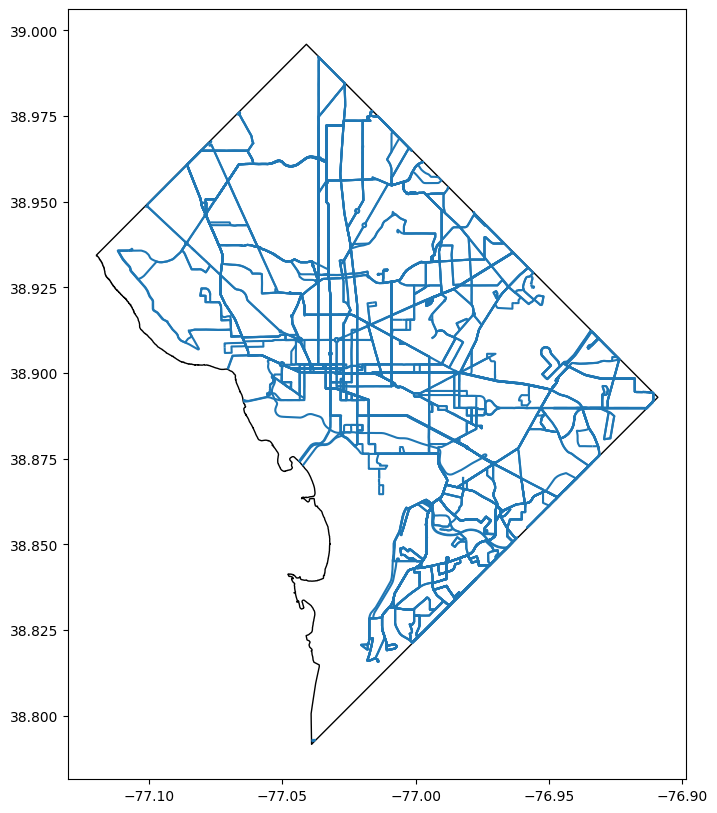

In [43]:
map_routes = df.geometry.unique()
map_routes = gpd.GeoDataFrame({'geometry':map_routes})
#Plot the grid on the map
res_intersection = map_routes.overlay(DC, how='intersection')
ax = res_intersection.plot(facecolor='none', figsize=(10, 10))
ax = DC.plot(ax=ax, facecolor='none',edgecolor='k')
ax.plot(ax=ax)

In [38]:
type(map_routes)

geopandas.array.GeometryArray

In [23]:
routes_lines = {}

#There were two data with
#multilinestring creating problem so to eleminate that we added this line
linestringclass = type(df.iloc[0].geometry)

for index,row in df.iterrows():
    if(type(row.geometry)!=linestringclass):
        continue
    if(type(routes_lines.get(row.ROUTE, None)) == type(None)):
        routes_lines[row.ROUTE] = [row.geometry]
    else:
        routes_lines[row.ROUTE].append(row.geometry)

In [24]:
route_linestring = {}
for route in routes_lines:
    multi_line = geometry.MultiLineString(routes_lines[route])
    merged_line = ops.linemerge(multi_line)
    route_linestring[route] = merged_line

In [25]:
route_length = {}
for route in route_linestring:
    map_segment = gpd.GeoDataFrame({'geometry':[route_linestring[route]]})
    project = partial(pyproj.transform,pyproj.Proj('EPSG:4326'), pyproj.Proj('EPSG:32633'))
    line = transform(project, route_linestring[route])
    route_length[route] = line.length

length of this route: 26208.60588478569 meters


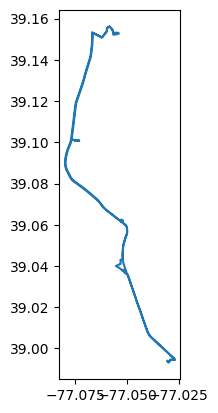

In [48]:
count=0
for route in routes_lines:
    multi_line = geometry.MultiLineString(routes_lines[route])
    merged_line = ops.linemerge(multi_line)
    map_segment = gpd.GeoDataFrame({'geometry':[merged_line]})
    print("length of this route: "+str(route_length[route]) + " meters")
    map_segment.plot()
    count+=1
    if(count>0):
        break

In [26]:
df = pd.DataFrame(route_length, index=[0])
df.to_csv('route_length.csv', index=False, header=True)

In [27]:
Bus_Frequency = os.path.join(os.getcwd(), "busdata", "bus_frequency.csv")
print(Bus_Frequency)

bus_freq_df = pd.read_csv(Bus_Frequency)

C:\Users\Jignasu\Documents\Virginia tech\fall22\urban\project2\busdata\bus_frequency.csv


In [28]:
Bus_Route_Len = os.path.join(os.getcwd(), "busdata", "route_length.csv")
print(Bus_Route_Len)

bus_route_len_df = pd.read_csv(Bus_Route_Len)

C:\Users\Jignasu\Documents\Virginia tech\fall22\urban\project2\busdata\route_length.csv


In [29]:
route_carbon_footprint = []
for index, route in bus_freq_df.iterrows():
    dist = bus_route_len_df.iloc[0][route["Routes"]]
    carbon_footprint = dist*12*60/route["minutes"]
    route_carbon_footprint.append({"route": route["Routes"], "carbon_footprint": carbon_footprint})
carbon_footprint_df = pd.DataFrame.from_dict(route_carbon_footprint)

In [30]:
carbon_footprint_df.to_csv('route_carbon_footprint.csv', index=False, header=True)

In [31]:
route_carbon_footprint = os.path.join(os.getcwd(), "busdata", "route_carbon_footprint.csv")
print(route_carbon_footprint)
carbon_footprint_df = pd.read_csv(route_carbon_footprint)
combined_carbon_footprint = carbon_footprint_df["carbon_footprint"].sum()

C:\Users\Jignasu\Documents\Virginia tech\fall22\urban\project2\busdata\route_carbon_footprint.csv


In [32]:
carbon_footprint_per_person = combined_carbon_footprint / (35000)

In [33]:
print(str(carbon_footprint_per_person/1000)+" km carbon footprint per person")

5.005586692720274 km carbon footprint per person
